In [2]:
!git clone --recursive https://github.com/WongKinYiu/yolov9.git
%cd yolov9/

Cloning into 'yolov9'...
remote: Enumerating objects: 668, done.
remote: Counting objects: 100% (290/290), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 668 (delta 222), reused 199 (delta 199), pack-reused 378
Receiving objects: 100% (668/668), 3.22 MiB | 15.28 MiB/s, done.
Resolving deltas: 100% (269/269), done.
/kaggle/working/yolov9


In [3]:
import os
HOME = os.getcwd()
print(HOME)

/kaggle/working/yolov9


In [4]:
!pip install -r requirements.txt -q
!pip install supervision -q

In [5]:
!wget -P {HOME} -q https://storage.googleapis.com/adonaivera_certified/test.jpeg
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt

In [6]:
import torch
import cv2
import numpy as np
from models.common import DetectMultiBackend
from utils.general import non_max_suppression, scale_boxes
from utils.torch_utils import select_device, smart_inference_mode
from utils.augmentations import letterbox
import PIL.Image
import supervision as sv

@smart_inference_mode()
def predict(image_path, weights='yolov9-c.pt', imgsz=640, conf_thres=0.1, iou_thres=0.45, device='0', data='data/coco.yaml'):
    # Initialize
    device = select_device(device)
    model = DetectMultiBackend(weights, device=device, fp16=False, data=data)
    stride, names, pt = model.stride, model.names, model.pt

    # Load image
    image = PIL.Image.open(image_path)
    img0 = np.array(image)
    # print(img0.shape)
    assert img0 is not None, f'Image Not Found {image_path}'
    img = letterbox(img0, imgsz, stride=stride, auto=True)[0]
    img = img[:, :, ::-1].transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    img = torch.from_numpy(img).to(device).float()
    img /= 255.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
    # print(img.shape)
    # Init bounding box annotator and label annotator
    bounding_box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator(text_position=sv.Position.CENTER)

    # Inference
    pred = model(img, augment=False, visualize=False)

    # Apply NMS
    pred = non_max_suppression(pred[0][0], conf_thres, iou_thres, classes=None, max_det=1000)
    print(pred[0].shape)

    # Process detections
    for i, det in enumerate(pred):
        print(det.shape)
        if len(det):
            det[:, :4] = scale_boxes(img.shape[2:], det[:, :4], img0.shape).round()
            for *xyxy, conf, cls in reversed(det):
                # print(xyxy[0])
                label = f'{names[int(cls)]} {conf:.2f}'
                # Transform detections to supervisions detections
                detections = sv.Detections(
                    xyxy=torch.stack(xyxy).cpu().numpy().reshape(1, -1),
                    class_id=np.array([int(cls)]),
                    confidence=np.array([float(conf)])
                )

                # Labels
                labels = [
                    f"{class_id} {confidence:0.2f}"
                    for class_id, confidence
                    in zip(detections.class_id, detections.confidence)
                ]

                img0 = bounding_box_annotator.annotate(img0, detections)
                img0 = label_annotator.annotate(img0, detections, labels)

    return img0[:, :, ::-1]


In [7]:
%matplotlib inline

YOLO 🚀 v0.1-89-g93f1a28 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 839 layers, 68669632 parameters, 0 gradients, 241.4 GFLOPs


torch.Size([5, 6])
torch.Size([5, 6])


SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


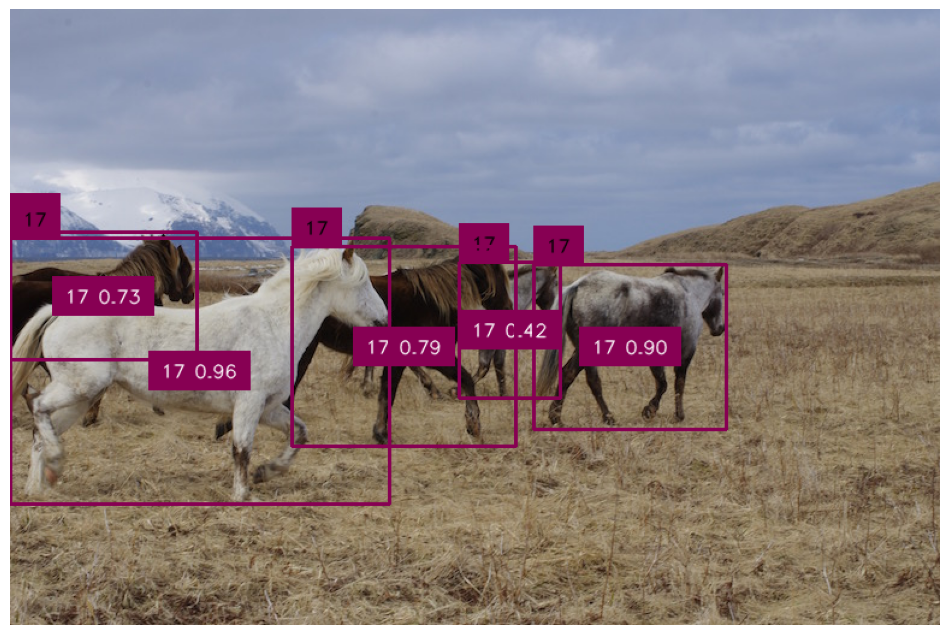

In [8]:
img = predict(image_path='/kaggle/working/yolov9/data/images/horses.jpg',weights=f'{HOME}/weights/yolov9-e.pt')
sv.plot_image(img)

In [9]:
import cv2
import numpy as np
import PIL
import torch
from utils.torch_utils import select_device, smart_inference_mode
from utils.general import non_max_suppression, scale_boxes
from models.common import DetectMultiBackend
import supervision as sv

def preprocess_frame(frame, imgsz=640):
    # Make a copy of the frame to ensure positive strides
    # Resize frame to target size
    frame = cv2.resize(frame, (imgsz, imgsz))
    # Convert frame to RGB (if it's in BGR)
    if frame.shape[2] == 3:
        frame = frame[:, :, ::-1]
    # Convert frame to torch tensor and normalize
    frame = frame.copy()
    img = torch.from_numpy(frame).float().permute(2, 0, 1) / 255.0
    return img

def preprocess_video(video_path, imgsz=640, batch_size=32):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # Preprocess each frame
        preprocessed_frame = preprocess_frame(frame, imgsz)
        frames.append(preprocessed_frame)
        if len(frames) == batch_size:
            # Yield a batch of preprocessed frames
            yield frames
            frames = []
    cap.release()
    if frames:
        # Yield remaining frames as a batch
        yield frames

def my_predict_video(video_path, weights='yolov9-c.pt', imgsz=640, conf_thres=0.1, iou_thres=0.45, device='0', data='data/coco.yaml'):
    # Initialize
    device = select_device(device)
    model = DetectMultiBackend(weights, device=device, fp16=False, data=data)
    stride, names, pt = model.stride, model.names, model.pt

    # Init bounding box annotator and label annotator
    bounding_box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator(text_position=sv.Position.CENTER)

    # Process video frames
    for batch_frames in preprocess_video(video_path, imgsz=imgsz):
        # print(batch_frames[0].shape)
        # Stack frames into a tensor
        img = torch.stack(batch_frames, dim=0).to(device)

        # Inference
        pred = model(img, augment=False, visualize=False)

        # Apply NMS
        pred = non_max_suppression(pred[0][0], conf_thres, iou_thres, classes=None, max_det=1000)

        # Process detections
        for i, det in enumerate(pred):
            if len(det):
                # Convert detections to numpy array
                det = det.cpu().numpy()
                det[:, :4] = scale_boxes(img.shape[2:], det[:, :4], batch_frames[0].shape).round()
                for *xyxy, conf, cls in reversed(det):
                    label = f'{names[int(cls)]} {conf:.2f}'
                    xyxy = torch.tensor(xyxy)
                    # Transform detections to supervisions detections
                    # xyxy = np.array(xyxy)
                    detections = sv.Detections(
                        xyxy=torch.stack(xyxy).cpu().numpy().reshape(1, -1),
                        class_id=np.array([int(cls)]),
                        confidence=np.array([float(conf)])
                    )

                    # Labels
                    labels = [
                        f"{class_id} {confidence:0.2f}"
                        for class_id, confidence
                        in zip(detections.class_id, detections.confidence)
                    ]

                    frame = bounding_box_annotator.annotate(frame, detections)
                    frame = label_annotator.annotate(frame, detections, labels)

    return frame

# Example usage
video_path = '/content/3042473-uhd_3840_2160_30fps.mp4'
# output_frame = my_predict_video(video_path, weights="/content/yolov9/weights/yolov9-c.pt")
out_frames = preprocess_video("/content/yolov9/weights/yolov9-c.pt")
for i in out_frames:
  print(i)
# Now you can do something with the output frame, like displaying it or saving it
# cv2.imshow("Output", output_frame)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [10]:
image = PIL.Image.open("/kaggle/working/yolov9/data/images/horses.jpg")
img0 = np.array(image)
    # print(img0.shape)
assert img0 is not None, f'Image Not Found {"/kaggle/working/yolov9/data/images/horses.jpg"}'
img = letterbox(img0, 640, stride=stride, auto=True)[0]
img = img[:, :, ::-1].transpose(2, 0, 1)
img = np.ascontiguousarray(img)
img = torch.from_numpy(img).to(device).float()
img /= 255.0
if img.ndimension() == 3:
    img = img.unsqueeze(0)
    print(img)

NameError: name 'stride' is not defined

In [14]:
# out_frames = preprocess_video("/content/3042473-uhd_3840_2160_30fps.mp4")
# count=0
# for i in out_frames:
#   # print(i)
#   count+=1
# # print(len(out_frames))
# print(i[0].shape)
device = select_device('0')
model = DetectMultiBackend('/kaggle/working/yolov9/weights/yolov9-e.pt', device=device, fp16=False, data='data/coco.yaml')


stride, names, pt = model.stride, model.names, model.pt

# Load image
# image = PIL.Image.open(image_path)
#     img0 = np.array(image)
    # print(img0.shape)
#     assert img0 is not None, f'Image Not Found {image_path}'


conf_thres=0.1
iou_thres=0.45
cap = cv2.VideoCapture("/kaggle/input/dog-data/New Project - Made with Clipchamp.mp4")
frames = []
count = 0
while cap.isOpened():
    ret, frame = cap.read()
    count+=1
    if not ret:
        break
    img = letterbox(frame, 640, stride=stride, auto=True)[0]
    img = img[:, :, ::-1].transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    img = torch.from_numpy(img).to(device).float()
    img /= 255.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
#         print(img)
    bounding_box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator(text_position=sv.Position.CENTER)
    img0 = frame
    # Inference
    pred = model(img, augment=False, visualize=False)

    # Apply NMS
    pred = non_max_suppression(pred[0][0], conf_thres, iou_thres, classes=None, max_det=1000)
#     print(pred[0].shape)

    # Process detections
    for det in pred:
#         print(i)
        if len(det) and count % 10 == 0:
            det[:, :4] = scale_boxes(img.shape[2:], det[:, :4], img0.shape).round()
            for *xyxy, conf, cls in reversed(det):
                # print(xyxy[0])
                label = f'{names[int(cls)]} {conf:.2f}'
                # Transform detections to supervisions detections
                detections = sv.Detections(
                    xyxy=torch.stack(xyxy).cpu().numpy().reshape(1, -1),
                    class_id=np.array([int(cls)]),
                    confidence=np.array([float(conf)])
                )
                
                # Labels
                labels = [
                    f"{class_id} {confidence:0.2f}"
                    for class_id, confidence
                    in zip(detections.class_id, detections.confidence)
                ]
                
#                 img0 = bounding_box_annotator.annotate(img0, detections)
#                 img0 = label_annotator.annotate(img0, detections, labels)
            print(label)
#             sv.plot_image(img0[:, :, ::-1])
# print(count)
# ret, frame = cap.read()
# print(frame)

YOLO 🚀 v0.1-89-g93f1a28 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 839 layers, 68669632 parameters, 0 gradients, 241.4 GFLOPs


dog 0.94
dog 0.96
dog 0.95
dog 0.96
dog 0.95
dog 0.95
dog 0.92
dog 0.94
